# Computational Tools for Data Science Main Notebook
# Authored by:
## Cecilie Haslund Bertelsen - s201700
## Mustafa Berkay Akbulut - s242540
## Georgios Fragkiadoulakis - s242831

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Data Cleaning

### This part is done by our ex-team member <strong>Mona</strong> before she drop the course </b>
You can access the notebook using the following link https://github.com/cecil7525/CompToolsAirBNB/blob/main/DataCleanse.ipynb

In [2]:
df= pd.read_csv("./data_cleansed.csv")
df.head(3)

,id,source,name,description,neighborhood_overview,host_id,host_name,days_as_host,host_in_NY,host_about,...,instant_bookable,calculated_host_listings_count,private_bathroom,shared_bathroom,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_response_rate_int,host_acceptance_rate_int
0,572612125615500056,city scrape,10,76,0,358089614,Joshua,1505,True,0,...,True,2,0.0,1.0,False,False,True,False,100,94
1,45267941,city scrape,5,0,0,39162543,Jeff,3334,True,0,...,False,3,0.0,1.0,False,False,True,False,100,77
2,838141198693830649,city scrape,4,0,0,148571080,David,2562,False,63,...,False,5,2.0,0.0,True,False,False,False,0,0


# Data Engineering

### In this part, we are preparing our data to be used in clustering. We convert our all features in the dataframe to numerical data

#### First, we merged sentiment scores of names and decriptions of the listings. Because we wanted to see how much name and description positiveness effects the reviews
To see how sentiment scores of names and descriptions obtained using RoBERTa model, you can follow the following link https://github.com/cecil7525/CompToolsAirBNB/blob/sentiment/senti.ipynb

In [3]:
df_name_desc = pd.read_csv("./NYtrans6.csv")
df_name_desc = df_name_desc[["id", "name_sent", "desc_sent"]]

In [4]:
df = pd.merge(df, df_name_desc, on=["id"], how="inner")

In [5]:
# The columns that are considered to use in clustering
columns_considered = ["name_sent", "desc_sent", "days_as_host", "host_in_NY",
                      "host_about", "host_response_rate_int", "host_acceptance_rate_int", "host_is_superhost", 
                      "host_verifications", "host_has_profile_pic", "host_identity_verified", "accommodates", "bathrooms", 
                      "bedrooms", "beds", "amenities", "price", "minimum_nights", "maximum_nights", "availability_365", "number_of_reviews",
                      "instant_bookable", "calculated_host_listings_count", "private_bathroom", "shared_bathroom", 
                      "room_type_Entire home/apt", "room_type_Hotel room", "room_type_Private room", "room_type_Shared room"]

In [6]:
##id's stored in a different variable since it will not be included in clustering but later they will be added after clustering
ids = df["id"]

In [8]:
df_final = df[columns_considered]
df_final.head(3)

,name_sent,desc_sent,days_as_host,host_in_NY,host_about,host_response_rate_int,host_acceptance_rate_int,host_is_superhost,host_verifications,host_has_profile_pic,...,availability_365,number_of_reviews,instant_bookable,calculated_host_listings_count,private_bathroom,shared_bathroom,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,1,2,1505,True,0,100,94,True,2,True,...,336,6,True,2,0.0,1.0,False,False,True,False
1,1,2,5839,True,0,100,0,False,2,True,...,311,2,False,1,1.0,0.0,True,False,False,False
2,2,2,4823,True,74,100,0,False,1,True,...,154,8,False,1,2.0,0.0,True,False,False,False


In [9]:
#small modifications an some columns since they are not identified as number by pandas
df_final["host_about"] = df_final["host_about"].astype("int")
df_final["host_verifications"] = df_final["host_verifications"].astype("int")
df_final["amenities"] = df_final["amenities"].astype("int")
df_final[["host_in_NY", "host_is_superhost"]] = df_final[["host_in_NY", "host_is_superhost"]].astype("bool")

In [10]:
#selection of numerical and boolean columns. The boolean columns are also converted to numericals
numerical_cols = df_final.select_dtypes(include=[np.number]).columns.tolist()
boolean_cols = df_final.select_dtypes(include=[bool]).columns.tolist()
df_final[boolean_cols] = df_final[boolean_cols].astype(int)

In [11]:
#Scaling numbers since we don't want to larger magnitudes dominate the clustering
scaler = StandardScaler()
numerical_and_boolean = df_final[numerical_cols + boolean_cols]
scaled_numerical_boolean = scaler.fit_transform(numerical_and_boolean)

In [12]:
preprocessed_df = pd.DataFrame(scaled_numerical_boolean, columns=numerical_cols + boolean_cols)

#### Now we have converted and scaled dataframe ready to be clustered

# Clustering

## In this part, we are clustering the listings since we want to see how attributes are changing inter-clusters

### DBSCAN Clustering

##### DBSCAN algorithm needs two parameters beforehand. First, epsilon which indicates the maximum distance between two points for them to be considered as neighbors. The second is min_points which is the minimum number of points required to form a dense region.
##### Finding epsilon value: The k-distance graph is used to find the optimal epsilon value in the DBSCAN algorithm. The distance value at the curve point on the graph gives the value

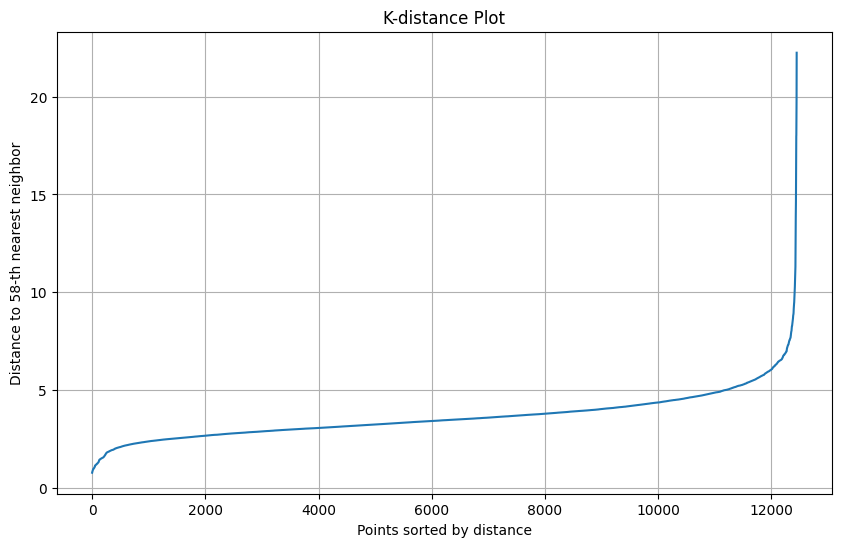

In [13]:
from sklearn.neighbors import NearestNeighbors

# setting min_samples for the DBSCAN => rule of thumb: two times of dimension of the dataframe
min_samples = len(df_final.columns)*2  # Set your min_samples for DBSCAN

# Fit Nearest Neighbors
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(preprocessed_df)
distances, indices = nbrs.kneighbors(preprocessed_df)

# Get the distances to the k-th nearest neighbor (min_samples)
k_distance = distances[:, min_samples - 1]  # Selecting the distance to the min_samples-neighbor

# Sort the K-distance
k_distance_sorted = np.sort(k_distance)

# Plot the K-distance graph
plt.figure(figsize=(10, 6))
plt.plot(k_distance_sorted)
plt.title('K-distance Plot')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {min_samples}-th nearest neighbor')
plt.grid(True)
plt.show()

##### We choose the epsilon value as 7 in this case 

In [14]:
eps = 7  # Maximum distance between two samples for them to be considered as in the same neighborhood chosen from graph

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(preprocessed_df)

# Add cluster labels to the original data
df_final['cluster'] = clusters

In [15]:
# Count clusters and noise points
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)  # -1 indicates noise
n_noise = list(clusters).count(-1)

print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')

Estimated number of clusters: 4
Estimated number of noise points: 37


##### We have found 4 clusters and 37 noise points

#### We used a Support Vector Classifier (SVC) to understand the most significant columns considered in clustering. We trained the SVC model and used permutation importance to see which features are contributed most

In [168]:
X = preprocessed_df  # Features
y = df_final['cluster']  # Targets based on clustering

#Support Vector Classifier with rbf kernel to assess non-linear relationships
rf_model = SVC(kernel="rbf")
rf_model.fit(X, y)

#Feature Importances
feature_importance = permutation_importance(rf_model, X, y, n_repeats=10, random_state=45)

#creating a datadrame to assess the results
feature_names = X.columns
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance.importances_mean})

#sort feature importances
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

feature_importances_df.head(3)

,Feature,Importance
22,host_has_profile_pic,0.031655
28,room_type_Shared room,0.015173
26,room_type_Hotel room,0.013944


#### As you can see, most significant features are considered as whether the host has profile picture and the room type 
#### Therefore, we ended up with the generated clusters as follows:
1. Host has profile picture and room type is Entire home
2. Host has profile picture and room type is private room
5. Host has profile picture and room type is shared room
6. Host has no profile picture and room type is either Entire home or private room

# Feature Engineering

## In this part, we are enriching dataset before executing frequent itemsets algorithm and association rules.
### Enrichments were done:
1. Add sentiment scores of the comments from reviews
2. Add most important amenities obtained from TF-IDF scores

In [16]:
#Concatenate ids that have stored before back to our final clustered dataframe. 
#Because it will be used in merging of sentiment scores of the reviews 
df_fin = pd.concat([ids, df_final], axis=1).dropna()
#Clear the noises that is not clustered by DBSCAN
df_fin = df_fin[df_fin['cluster'] != -1]

#### We merged sentiment scores of the reviews with associated sentiment category (VG: Very Good, G: Good, N: Neutral, B: Bad, VB: Very Bad)
See the following link how we used RoBERTa model to get sentiment scores https://github.com/cecil7525/CompToolsAirBNB/blob/sentiment/senti.ipynb

In [17]:
#Read the sentiment scores data generated by Georgios
df_sentiment = pd.read_csv("./NYtransREVnSCALE3.csv", header=[0], low_memory=False)
df_final_sentiment = df_sentiment[["listing_id", "scaled"]]
df_joined = pd.merge(df_final_sentiment, df_fin, left_on="listing_id", right_on="id", how="inner")

#### We merged most important amenitites that affects comments in the reviews. TF-IDF implementation

In [18]:
import pandas as pd
import string
import ast 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
from collections import Counter

nltk.download('stopwords')
# read the original data to make the analysis
amenities_data = pd.read_csv('listings.csv')

# Function: Preprocessing reviews
def preprocess_text(text):
    text = text.lower()  
    text = text.translate(str.maketrans('', '', string.punctuation))  
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]  
    return ' '.join(tokens)

# Applying preprocessing to the reviews
df_sentiment['processed_comments'] = df_sentiment['comments'].astype(str).apply(preprocess_text)

# TF-IDF vectorizer
tfidf = TfidfVectorizer()  
tfidf_matrix = tfidf.fit_transform(df_sentiment['processed_comments'])
tfidf_terms = tfidf.get_feature_names_out()

# Function: Getting the amenities from the listings.csv
def extract_amenities(amenities_string):
    try:
        return ast.literal_eval(amenities_string)
    except:
        return []

amenities_data['processed_amenities'] = amenities_data['amenities'].apply(extract_amenities)

# Flattening and normalizing the list of amenities for comparison process
all_amenities = set(
    amenity.lower() for amenities in amenities_data['processed_amenities'] for amenity in amenities
)

# Function: Comparing the TF-IDF terms with the amenities
def find_matches(tfidf_terms, amenities):
    matches = [term for term in tfidf_terms if term in amenities]
    return list(set(matches))

# Applying the function for comparing terms with amenities
df_sentiment['tfidf_amenity_matches'] = df_sentiment['processed_comments'].apply(
    lambda x: find_matches(x.split(), all_amenities)
)

# Get the unique mentions of the amenities for specific listing
amenitites_df = df_sentiment[["listing_id", "tfidf_amenity_matches"]]
grouped = amenitites_df.groupby('listing_id').agg(
    all_mentions=('tfidf_amenity_matches', lambda x: list(set([item for sublist in x for item in sublist])))  # Flatten lists
).reset_index()

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1007)>


In [19]:
#Get necessary columns
staging_important_amenities = grouped[["listing_id", "all_mentions"]]

In [20]:
#Convert ["kitchen", "wi-fi", "coffee" ...] arrays to distinct amenities, i.e. distribute among all columns
expanded = staging_important_amenities['all_mentions'].apply(lambda x: pd.Series(x))
expanded.columns = [f'amenity_{i+1}' for i in range(expanded.shape[1])]

final_important_amenities = pd.concat([staging_important_amenities, expanded], axis=1).drop(columns=["all_mentions"])

In [21]:
df_all_information = pd.merge(df_joined, final_important_amenities, on="listing_id", how="inner")
df_all_information.head(3)

,listing_id,scaled,id,name_sent,desc_sent,days_as_host,host_in_NY,host_about,host_response_rate_int,host_acceptance_rate_int,...,amenity_14,amenity_15,amenity_16,amenity_17,amenity_18,amenity_19,amenity_20,amenity_21,amenity_22,amenity_23
0,2595,VG,2595,1,2,5840,1,76,67,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2595,VG,2595,1,2,5840,1,76,67,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2595,VG,2595,1,2,5840,1,76,67,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Frequent Itemsets and Association Rules

## In this part, we mined cluster-based association rules

### We needed to categorize all the dataframe to obtain basket-like transactions to increase interpretability of the data

In [22]:
def categorize_all_df(data):
    data['name_sent'] = data['name_sent'].replace({0: 'name_negative', 1: 'name_neutral', 2: 'name_positive'})
    data['desc_sent'] = data['desc_sent'].replace({0: 'desc_negative', 1: 'desc_neutral', 2: 'desc_positive'})
    data['days_as_host'] = pd.cut(data['days_as_host'], bins=[i*365 for i in range(20)], labels=[f"{i} years" for i in range(19)])
    data['host_in_NY'] = data['name_sent'].replace({0: 'host_not_in_NY', 1: 'host_in_NY'})
    data['host_about'] = pd.cut(data['host_about'], bins=[0,50,100,150,1000], labels=["very_short_about", "short_about", "moderate_about", "long_about"])
    data['host_response_rate_int'] = pd.cut(data['host_response_rate_int'], bins=[0,25,50,75,100], labels=["very_low_response", "low_response", "moderate_response", "high_response"])
    data['host_acceptance_rate_int'] = pd.cut(data['host_acceptance_rate_int'], bins=[0,25,50,75,100], labels=["very_low_acceptance", "low_acceptance", "moderate_acceptance", "high_acceptance"])
    data['host_is_superhost'] = data['host_is_superhost'].replace({0: 'host_is_not_superhost', 1: 'host_is_superhost'})
    data['host_verifications'] = data['host_verifications'].replace({0: 'no_verification', 1: '1_verification', 2: '2_verification', 3: 'all_verification'})
    data['host_identity_verified'] = data['host_identity_verified'].replace({0: 'host_identity_not_verified', 1: 'host_identity_verified'})
    data['accommodates'] = data['accommodates'].apply(lambda x: f"{x} accommodates")
    data['bathrooms'] = data['bathrooms'].apply(lambda x: f"{x} bathrooms")
    data['bedrooms'] = data['bedrooms'].apply(lambda x: f"{x} bedrooms")
    data['beds'] = data['beds'].apply(lambda x: f"{x} beds")
    data['amenities'] = data['amenities'].apply(lambda x: f"{x} amenities")
    data['price'] = pd.cut(data['price'], bins=[0,50,100,150,200,250,10000], labels=["very_cheap", "cheap", "moderate", "somehow expensive", "expensive", "very expensive"])
    data['minimum_nights'] = data['minimum_nights'].apply(lambda x: f"{x} min_nights")
    data['maximum_nights'] = data['maximum_nights'].apply(lambda x: f"{x} max_nights")
    data['availability_365'] = pd.cut(data['availability_365'], bins=[0,30,60,90,120,150,180,210,240,270,300,330,367], labels=[f"available_{i}_{i+1}_months" for i in range(12)])
    data['number_of_reviews'] = pd.cut(data['number_of_reviews'], bins=[0,10,50,200,500,10000], labels=["very_low_number_of_rev", "low_number_of_rev", "moderate_number_of_rev", "high_of_rev", "very_high_number_of_rev"])
    data['instant_bookable'] = data['instant_bookable'].replace({0: 'not_instant_bookable', 1: 'instant_bookable'})
    data['calculated_host_listings_count'] = pd.cut(data['calculated_host_listings_count'], bins=[0,2,5,15,50,500], labels=["very_low_number_of_listings", "low_number_of_listings", "moderate_number_of_listings", "high_of_listings", "very_high_number_of_listings"])
    data['private_bathroom'] = data['private_bathroom'].apply(lambda x: f"{x} private_bathroom")
    data['shared_bathroom'] = data['shared_bathroom'].apply(lambda x: f"{x} shared_bathroom")
    data = data.astype(str)
    return data

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


### First cluster (host has profile picture and room type is entire home)

In [23]:
first_cluster_df = df_all_information[(df_all_information["cluster"] == 0) & (df_all_information["room_type_Entire home/apt"] == 1)]
first_cluster_df = first_cluster_df.drop(columns=["listing_id", "id", "host_has_profile_pic", "room_type_Entire home/apt", 
                                                  "room_type_Hotel room", "room_type_Private room", "room_type_Shared room", "cluster"])
first_cluster_df = categorize_all_df(first_cluster_df)

#### Apriori and association rules

In [24]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [25]:
transactions = []
# We iterate over all the dataframe to obtain list-based transactions to use in A-priori algorithm
for _, row in first_cluster_df.iterrows():
    temp = [item for item in row.tolist() if item != 'nan']
    transactions.append(temp)

In [26]:
te = TransactionEncoder()
te_data = te.fit(transactions).transform(transactions)
transact_df = pd.DataFrame(te_data, columns=te.columns_)

# Apriori algorithm with minimum support with 0.5 
#meaning just consider the items that have been included at least half of the transactions
frequent_itemsets = apriori(transact_df, min_support=0.5, use_colnames=True)

In [27]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.013, num_itemsets=int(frequent_itemsets.count().support))

In [28]:
rules[(rules["consequents"].isin([frozenset({'VG'}), frozenset({'G'}), frozenset({'N'}), frozenset({'B'}), frozenset({'VB'})]) ) & (rules["lift"] >= 1.01348)]["antecedents"].unique()

array([frozenset({'high_response', '30 min_nights', 'breakfast'}),
       frozenset({'high_response', '30 min_nights', '0.0 shared_bathroom', 'breakfast'}),
       frozenset({'kitchen', 'high_response', '30 min_nights', 'breakfast'}),
       frozenset({'breakfast', 'high_response', 'kitchen', '0.0 shared_bathroom', '30 min_nights'})],
      dtype=object)

#### We concluded that if a customer rent an entire home that have private bathroom (0 shared bathroom), kitchen and breakfast service for at least 30 days and get high response from the host, the probability of leaving positive feedback increases

### Second cluster (host has profile picture and room type is private room)

In [29]:
second_cluster_df = df_all_information[(df_all_information["cluster"] == 0) & (df_all_information["room_type_Private room"] == 1)]
second_cluster_df = second_cluster_df.drop(columns=["listing_id", "id", "host_has_profile_pic", "room_type_Entire home/apt", 
                                                    "room_type_Hotel room", "room_type_Private room", "room_type_Shared room", "cluster"])
second_cluster_df = categorize_all_df(second_cluster_df)

In [30]:
transactions_2 = []

for _, row in second_cluster_df.iterrows():
    temp = [item for item in row.tolist() if item != 'nan']
    transactions_2.append(temp)

In [31]:
te = TransactionEncoder()
te_data = te.fit(transactions_2).transform(transactions_2)
transact_df_2 = pd.DataFrame(te_data, columns=te.columns_)

# Apriori algorithm with minimum support with 0.5 
#meaning just consider the items that have been included at least half of the transactions
frequent_itemsets = apriori(transact_df_2, min_support=0.5, use_colnames=True)

In [32]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.01, num_itemsets=int(frequent_itemsets.count().support))

In [33]:
rules[(rules["consequents"].isin([frozenset({'VG'}), frozenset({'G'}), frozenset({'N'}), frozenset({'B'}), frozenset({'VB'})]) ) & (rules["lift"] >= 1.0126)]["antecedents"].unique()

array([frozenset({'host_identity_verified', '1.0 bathrooms', 'very_low_number_of_listings'}),
       frozenset({'1.0 bedrooms', 'host_identity_verified', '1.0 bathrooms', 'very_low_number_of_listings'}),
       frozenset({'safe', 'host_identity_verified', '1.0 bathrooms', 'very_low_number_of_listings'}),
       frozenset({'host_identity_verified', '1.0 bathrooms', 'coffee', 'safe', 'very_low_number_of_listings'})],
      dtype=object)

#### We concluded that if customers rent a private room that have 1 bathroom (regardless of shared or private), 1 bedroom and coffee service, also host identity is verified, the customer feels safe and the probability of leaving positive feedback increases :)

### Third cluster (host has profile picture and the room type is shared room)

In [34]:
third_cluster_df = df_all_information[(df_all_information["cluster"] == 2)]
third_cluster_df = third_cluster_df.drop(columns=["listing_id", "id", "host_has_profile_pic", "room_type_Entire home/apt",
                                                  "room_type_Hotel room", "room_type_Private room", "room_type_Shared room", "cluster"])
third_cluster_df = categorize_all_df(third_cluster_df)

In [35]:
transactions_3 = []

for _, row in third_cluster_df.iterrows():
    temp = [item for item in row.tolist() if item != 'nan']
    transactions_3.append(temp)

In [36]:
te = TransactionEncoder()
te_data = te.fit(transactions_3).transform(transactions_3)
transact_df_3 = pd.DataFrame(te_data, columns=te.columns_)

# Apriori algorithm with minimum support with 0.5 
#meaning just consider the itemsets that have been included at least half of the transactions
#frequent_itemsets = apriori(transact_df_3, min_support=1, use_colnames=True)

#### Nothing to conclude for this cluster because every feature in every shared room listing have exactly the same features

### Last cluster (host has no profile picture and room type is either entire home or private room)

In [37]:
fourth_cluster_df = df_all_information[(df_all_information["cluster"] == 1)]
fourth_cluster_df = fourth_cluster_df.drop(columns=["listing_id", "id", "host_has_profile_pic", "room_type_Entire home/apt", "room_type_Hotel room", "room_type_Private room", 
                                                    "room_type_Shared room", "cluster"])
fourth_cluster_df = categorize_all_df(fourth_cluster_df)

In [38]:
transactions_4 = []

for _, row in fourth_cluster_df.iterrows():
    temp = [item for item in row.tolist() if item != 'nan']
    transactions_4.append(temp)

In [39]:
te = TransactionEncoder()
te_data = te.fit(transactions_4).transform(transactions_4)
transact_df_4 = pd.DataFrame(te_data, columns=te.columns_)

# Apriori algorithm with minimum support with 0.5 
#meaning just consider the itemsets that have been included at least half of the transactions
#frequent_itemsets = apriori(transact_df_3, min_support=1, use_colnames=True)

#### Also nothing to conclude for this one because every feature in every listings in this cluster have exactly the same features